In [100]:
import matplotlib.pyplot as plt
import os
import shutil
import zipfile
import tensorflow as tf
import keras_tuner
from pathlib import Path
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Retrieve Lego Brick Dataset

In [101]:
from kaggle.api.kaggle_api_extended import KaggleApi
from kaggleinfo import KAGGLE_USERNAME, KAGGLE_KEY

# Define environment variables
os.environ["KAGGLE_USERNAME"] = KAGGLE_USERNAME
os.environ["KAGGLE_KEY"] = KAGGLE_KEY

api = KaggleApi()

# Authenicate with Kaggle API
api.authenticate()

In [102]:
print(tf.config.list_physical_devices("GPU"))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [103]:
DATASET_IDENTIFIER = "pacogarciam3/lego-brick-sorting-image-recognition"

# Lists files for given parameter dataset from Kaggle link:
# https://www.kaggle.com/datasets/pacogarciam3/lego-brick-sorting-image-recognition/data

# Another good kaggle link to consider for bigger dataset:
# https://www.kaggle.com/datasets/joosthazelzet/lego-brick-images?select=dataset
api.dataset_list_files(dataset=DATASET_IDENTIFIER).files

[Image_Count_Summary.jpg,
 background_backlit_B.jpg,
 example_1_Cropped Image.jpg,
 example_2_Base Image.jpg,
 background_backlit_A.jpg,
 ImageSetKey.csv]

In [104]:
# Path to folder containing dataset
LEGO_PATH = Path("lego-brick-sorting-image-recognition")

# Path variable to base images.
BASE_IMAGES_PATH = LEGO_PATH / "Base Images"

In [105]:
# Check if dataset exists
if not LEGO_PATH.is_dir():
    print("Downloading dataset...")

    # Download dataset
    api.dataset_download_files(dataset=DATASET_IDENTIFIER, path=".")

    # Unzip dataset
    with zipfile.ZipFile("lego-brick-sorting-image-recognition.zip", "r") as zip_ref:
        zip_ref.extractall("lego-brick-sorting-image-recognition")

else:
    print(f"Dataset already exists in {LEGO_PATH} folder!")

Dataset already exists in lego-brick-sorting-image-recognition folder!


In [106]:
# Split dataset into train/test folders in data folder
if not Path("data").is_dir():
    for folder in ("train", "valid"):
        # Create directory for train or test
        os.makedirs(f'data/{folder}')

        # Loop through all subfolders in cropped images folder
        for subfolder in os.listdir(BASE_IMAGES_PATH):
            
            # Get directory of subfolders
            dir = BASE_IMAGES_PATH / subfolder
            
            # Get all .jpg images in subfolder path
            images = list(dir.glob("*.jpg"))

            # Get 90% of images
            index = int(0.90 * len(images))

            # Partition list
            if folder == "train":
                images = images[:index]
            
            else:
                images = images[index:]
            
            # Make directory of subfolder in new data folder
            os.makedirs(f'data/{folder}/{subfolder}')

            # Loop through images
            for image in images:
                # Copy images to new folder
                shutil.copyfile(src=image, dst=f'data/{folder}/{subfolder}/{image.stem}.jpg')

In [107]:
DATA_PATH = Path("data")
TRAIN_PATH = DATA_PATH / "train"
VALID_PATH = DATA_PATH / "valid"

In [108]:
# Ensure that train-test split happened correctly
train_img_count = len(list(TRAIN_PATH.glob("*/*.jpg")))
test_img_count = len(list(VALID_PATH.glob("*/*.jpg")))

print(f'Number of total train images: {train_img_count} = {round((train_img_count / (train_img_count + test_img_count)) * 100)}%')
print(f'Number of total valid images: {test_img_count} = {round((test_img_count / (train_img_count + test_img_count)) * 100)}%')

Number of total train images: 4113 = 90%
Number of total valid images: 467 = 10%


In [109]:
def walk_through_dataset(path: Path):
    for dirpath, dirnames, filenames in os.walk(path):
        print(f'There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}')

In [110]:
walk_through_dataset(TRAIN_PATH)

There are 20 directories and 0 images in data\train
There are 0 directories and 194 images in data\train\Brick_1x1
There are 0 directories and 215 images in data\train\Brick_1x2
There are 0 directories and 169 images in data\train\Brick_1x3
There are 0 directories and 214 images in data\train\Brick_1x4
There are 0 directories and 211 images in data\train\Brick_2x2
There are 0 directories and 285 images in data\train\Brick_2x2_L
There are 0 directories and 172 images in data\train\Brick_2x2_Slope
There are 0 directories and 181 images in data\train\Brick_2x3
There are 0 directories and 217 images in data\train\Brick_2x4
There are 0 directories and 261 images in data\train\Plate_1x1
There are 0 directories and 190 images in data\train\Plate_1x1_Round
There are 0 directories and 296 images in data\train\Plate_1x1_Slope
There are 0 directories and 186 images in data\train\Plate_1x2
There are 0 directories and 195 images in data\train\Plate_1x2_Grill
There are 0 directories and 179 images i

In [111]:
walk_through_dataset(VALID_PATH)

There are 20 directories and 0 images in data\valid
There are 0 directories and 22 images in data\valid\Brick_1x1
There are 0 directories and 24 images in data\valid\Brick_1x2
There are 0 directories and 19 images in data\valid\Brick_1x3
There are 0 directories and 24 images in data\valid\Brick_1x4
There are 0 directories and 24 images in data\valid\Brick_2x2
There are 0 directories and 32 images in data\valid\Brick_2x2_L
There are 0 directories and 20 images in data\valid\Brick_2x2_Slope
There are 0 directories and 21 images in data\valid\Brick_2x3
There are 0 directories and 25 images in data\valid\Brick_2x4
There are 0 directories and 30 images in data\valid\Plate_1x1
There are 0 directories and 22 images in data\valid\Plate_1x1_Round
There are 0 directories and 33 images in data\valid\Plate_1x1_Slope
There are 0 directories and 21 images in data\valid\Plate_1x2
There are 0 directories and 22 images in data\valid\Plate_1x2_Grill
There are 0 directories and 20 images in data\valid\Pl

In [112]:
walk_through_dataset(BASE_IMAGES_PATH)

There are 20 directories and 0 images in lego-brick-sorting-image-recognition\Base Images
There are 0 directories and 216 images in lego-brick-sorting-image-recognition\Base Images\Brick_1x1
There are 0 directories and 239 images in lego-brick-sorting-image-recognition\Base Images\Brick_1x2
There are 0 directories and 188 images in lego-brick-sorting-image-recognition\Base Images\Brick_1x3
There are 0 directories and 238 images in lego-brick-sorting-image-recognition\Base Images\Brick_1x4
There are 0 directories and 235 images in lego-brick-sorting-image-recognition\Base Images\Brick_2x2
There are 0 directories and 317 images in lego-brick-sorting-image-recognition\Base Images\Brick_2x2_L
There are 0 directories and 192 images in lego-brick-sorting-image-recognition\Base Images\Brick_2x2_Slope
There are 0 directories and 202 images in lego-brick-sorting-image-recognition\Base Images\Brick_2x3
There are 0 directories and 242 images in lego-brick-sorting-image-recognition\Base Images\Bri

## Load Dataset

In [113]:
IMAGE_SIZE = (224, 224)

# Not using data folder
train_base = tf.keras.utils.image_dataset_from_directory(
    directory=TRAIN_PATH,
    shuffle=True,
    image_size=IMAGE_SIZE
)

valid_base = tf.keras.utils.image_dataset_from_directory(
    directory=VALID_PATH,
    shuffle=True,
    image_size=IMAGE_SIZE
)

class_names = train_base.class_names
print(class_names)

Found 4113 files belonging to 20 classes.
Found 467 files belonging to 20 classes.
['Brick_1x1', 'Brick_1x2', 'Brick_1x3', 'Brick_1x4', 'Brick_2x2', 'Brick_2x2_L', 'Brick_2x2_Slope', 'Brick_2x3', 'Brick_2x4', 'Plate_1x1', 'Plate_1x1_Round', 'Plate_1x1_Slope', 'Plate_1x2', 'Plate_1x2_Grill', 'Plate_1x3', 'Plate_1x4', 'Plate_2x2', 'Plate_2x2_L', 'Plate_2x3', 'Plate_2x4']


In [114]:
def batch_iterator(data):
    data = data.as_numpy_iterator()
    batch_data = data.next()

    return batch_data

batch = batch_iterator(train_base)
batch[0].shape

(32, 224, 224, 3)

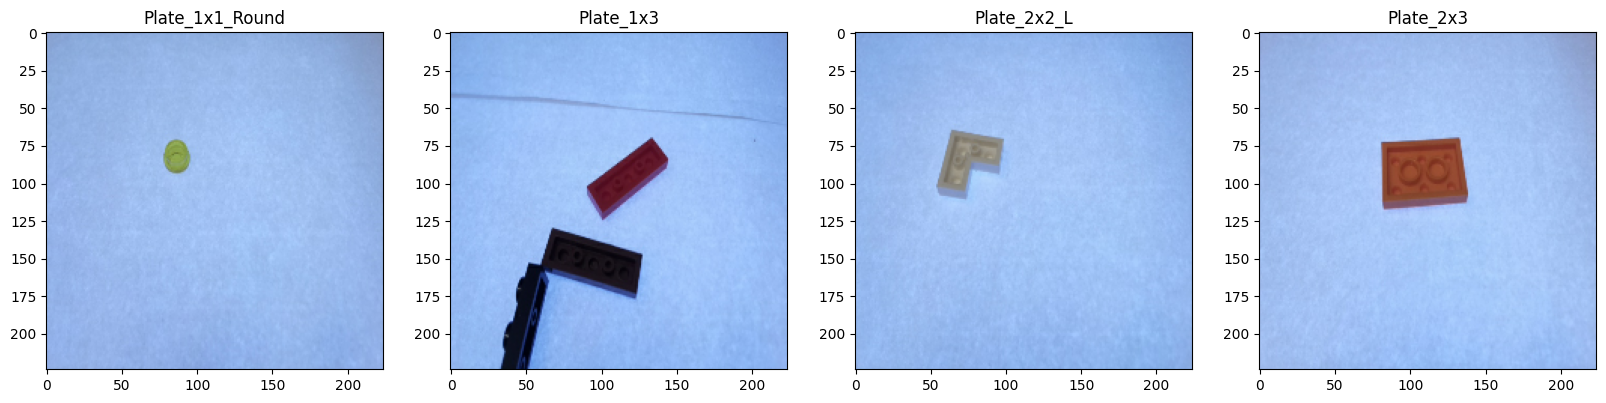

In [115]:
# Create 4 subplots
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))

# Get first four images from batch
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(class_names[batch[1][idx]])

## Preprocessing Data

In [116]:
def augment_images(images, labels):
    # tf.float32 automatically rescales pixels values between [0, 1]
    images = tf.image.convert_image_dtype(images, tf.float32)

    # Flip images left or right randomly
    images = tf.image.random_flip_left_right(images)   

    images = tf.image.central_crop(images, 0.9)
    print(f'Size after crop: {images.shape}')

    images = tf.image.resize(images, [IMAGE_SIZE[0], IMAGE_SIZE[1]])
    print(f'Size after resize: {images.shape}')
    
    # Rotate images 90 degrees randomly
    images = tf.image.rot90(images)
    
    return (images, labels)


In [117]:
# Rescale image values to be between 0-1
train_base = train_base.map(augment_images)

# Get batch
batch = batch_iterator(train_base)

Size after crop: (None, 202, 202, 3)
Size after resize: (None, 224, 224, 3)


In [118]:
# Check to see values are scaled correctly
print(f'Minimum length: {batch[0].min()}')
print(f'Maximum length: {batch[0].max()}')

Minimum length: 0.0
Maximum length: 255.0


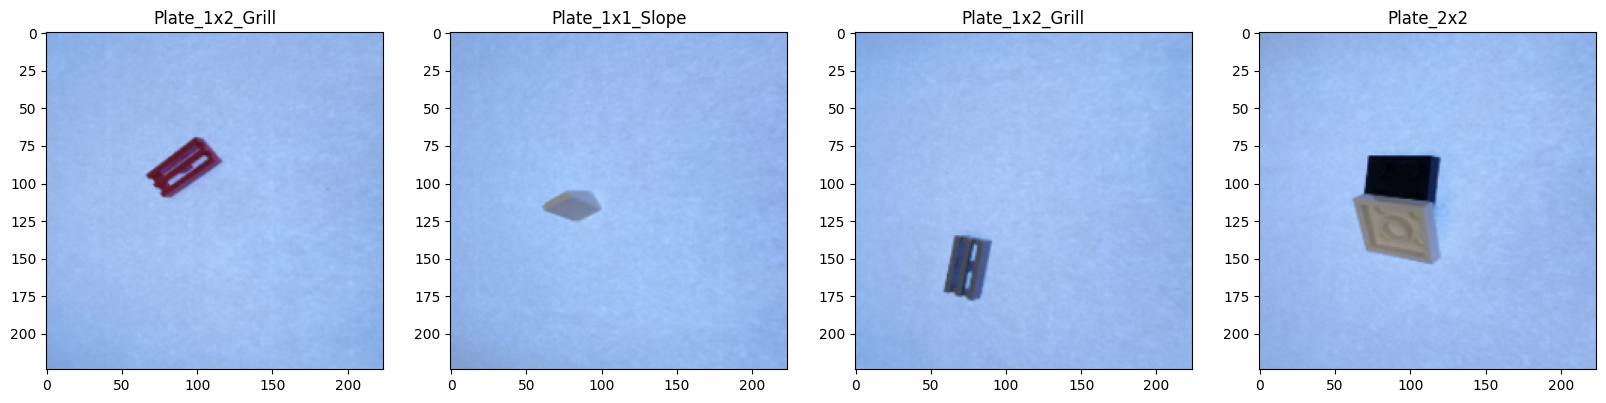

In [119]:
# Create 4 subplots
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))

# Get first four images from batch
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype("uint8"))
    ax[idx].title.set_text(class_names[batch[1][idx]])

## Build Deep Learning Model

In [120]:
# Set up logging
LOG_DIR = "logs"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=LOG_DIR)

In [135]:
def build_model():
    # Input shape (224, 224, 3) and input data in range of [0, 255]
    model = tf.keras.applications.EfficientNetV2B0(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

    # Freeze base model
    model.trainable = False

    # Add custom layers for specific task
    x = layers.GlobalAveragePooling2D()(model.output)
    x = layers.Dropout(0.2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(1024, activation="relu")(x)
    outputs = layers.Dense(len(class_names), activation="softmax")(x)

    final_model = tf.keras.Model(inputs=model.input, outputs=outputs)

    final_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
                    metrics=["accuracy"])
    
    return final_model

In [136]:
build_model().summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_14 (Rescaling)       (None, 224, 224, 3)  0           ['input_15[0][0]']               
                                                                                                  
 normalization_14 (Normalizatio  (None, 224, 224, 3)  0          ['rescaling_14[0][0]']           
 n)                                                                                               
                                                                                           

In [137]:
# Build model
model = build_model() 

# Trains model
hist = model.fit(train_base, epochs=20, validation_data=valid_base, callbacks=[tensorboard_callback])

Epoch 1/20
129/129 [==============================] - 24s 143ms/step - loss: 2.2504 - accuracy: 0.3817 - val_loss: 1.6542 - val_accuracy: 0.5482
Epoch 2/20
129/129 [==============================] - 17s 132ms/step - loss: 1.3974 - accuracy: 0.6110 - val_loss: 1.2145 - val_accuracy: 0.6702
Epoch 3/20
129/129 [==============================] - 17s 135ms/step - loss: 1.0702 - accuracy: 0.7053 - val_loss: 1.0414 - val_accuracy: 0.6788
Epoch 4/20
129/129 [==============================] - 17s 135ms/step - loss: 0.9020 - accuracy: 0.7469 - val_loss: 0.9046 - val_accuracy: 0.7195
Epoch 5/20
129/129 [==============================] - 19s 147ms/step - loss: 0.7868 - accuracy: 0.7807 - val_loss: 0.8727 - val_accuracy: 0.7173
Epoch 6/20
129/129 [==============================] - 18s 139ms/step - loss: 0.7079 - accuracy: 0.8045 - val_loss: 0.7961 - val_accuracy: 0.7388
Epoch 7/20
129/129 [==============================] - 17s 133ms/step - loss: 0.6458 - accuracy: 0.8140 - val_loss: 0.7560 - val_ac

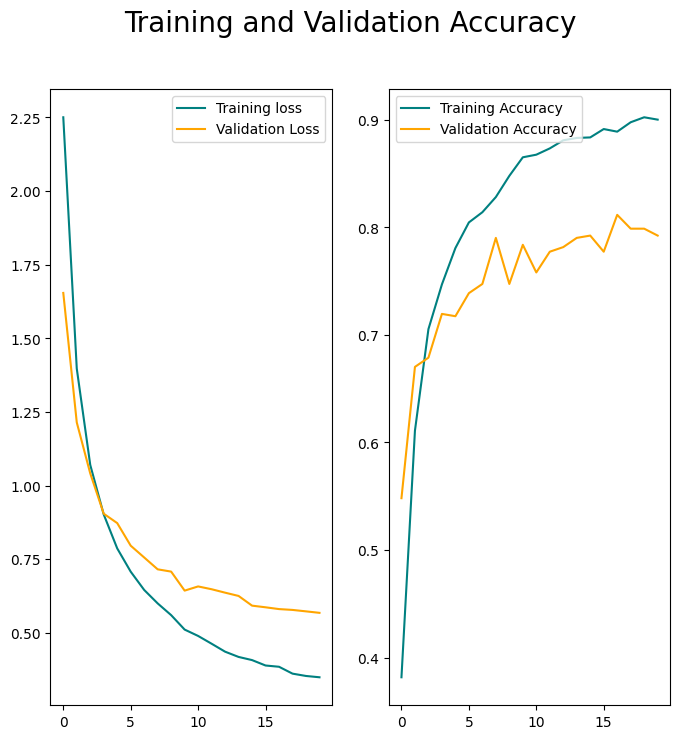

In [140]:
fig = plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
plt.plot(hist.history["loss"], color="teal", label="Training loss")
plt.plot(hist.history["val_loss"], color="orange", label="Validation Loss")
fig.suptitle("Training and Validation Loss", fontsize=20)
plt.legend(loc="upper right")

plt.subplot(1, 2, 2)
plt.plot(hist.history["accuracy"], color="teal", label="Training Accuracy")
plt.plot(hist.history["val_accuracy"], color="orange", label="Validation Accuracy")
fig.suptitle("Training and Validation Accuracy", fontsize=20)
plt.legend(loc="upper left")
plt.show()

## Save Model